# <font color = blue> Digital Futures Data Science Programme </font>
## <font color = blue> Linear Regression Team Project - Auto Trader </font>

This project aims to simulate a business model which buys second-hand cars and resell them at higher prices. A prediction model, together with some business rules, will be developed to work out a profitable price for purchasing the used cars. Reference data is collected from Auto Trader using web scrapping tool.

### Install Packages

In [1]:
# pip install autotrader-scraper

In [2]:
# pip install cloudscraper 

### Import Libraries

In [3]:
## Webscrapping and reading data
from autotrader_scraper import get_cars, save_csv, save_json
import os

## Pandas and numpy
import pandas as pd
import numpy as np

## Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

## Standardisation
from sklearn.preprocessing import StandardScaler

## Modelling
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tools
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

## Assumptions Checking
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from statsmodels.stats.diagnostic import normal_ad

### Writing Functions

#### Webscraping Function

In [4]:
def return_results(make, model):
    
    """
    Function to run the get_cars webscrap for the make and model input
    -------------------------------------------------------------------
    make: make of the car
    model: car model
    """
    
    save_csv(results = get_cars(
            make = make,
            model = model,
            postcode = "N1 9UZ",
            radius = 1500,
            min_year = 2005,
            max_year = 2021,
            include_writeoff = "include",
            max_attempts_per_page = 5,
            verbose = True
          ))
    filename = make + '_' + model + '.txt'
    os.rename('scraper_output.csv', filename)

#### Printing Unique Values Function

In [5]:
def unique_values(df, variable):
    
    """
    Function to print unique values and their counts for a variable
    ----------------------------------------------------------------
    df: dataframe
    variable: variable in the dataframe
    """
    
    print(f'The variable {variable} has {len(df[variable].unique())} unique values: \n')
    print(f'{df[variable].unique()}')
    print(f'-------------------------------------------------------------------------- \n')

#### Data Cleaning Function

In [6]:
def data_clean(df):
    
    """
    Function for transforming the training and testing dataset
    -----------------------------------------------------------
    df: dataframe
    """
    
    ## Remove unwanted variables
    df.drop(['owners', 'name', 'link'], axis = 1, inplace = True)
    
    ## Code price as a numerical variable by removing the pound sign and the comma in the string for each observation, 
    ## then convert to float
    df.price = df.price.str.replace('£', '').str.replace(',', '').astype('float')
    
    ## Code engine as a numerical variable by removing the litre sign
    df.engine = df.engine.str.replace('L','').astype('float')
    
    ## Recoding \x96 in fuel to a dash
    df.fuel = df.fuel.str.replace('\x96', '-')
    
    ## Recode ULEZ
    ## 0 - Not ULEZ compatible
    ## 1 - ULEZ compatible
    df.ULEZ.fillna('Non ULEZ', inplace = True)
    df.ULEZ = df.ULEZ.astype('category')
    
    ## Remove observations with missing values (Needs to be done after recoding ULEZ since NaNs in ULEZ have meanings)
    df.dropna(axis = 0, how = 'any', inplace = True)
    
    ## Remove registration information from year
    df.year = df.year.str.split('(', expand = True)[0].str.strip().astype('category')
    
    ## Remove observations with Electric as fuel type since there are not enough data -- Limitation
    index_num = df[df['fuel'] == 'Electric'].index
    df.drop(index_num, axis = 0, inplace = True)
    
    ## Remove outliers
    df = df[df['price'] < 70000]
    
    ## Reordering the columns
    df = df[['model', 'mileage', 
             'BHP', 'transmission', 
             'fuel', 'body', 
             'ULEZ', 'engine', 
             'year', 'price']]
    
    return df

#### Data Transformation Function

In [7]:
def data_trans_x(df):
    
    """
    Function to perform transformation (e.g. encoding, introducing new columns) to the feature matrix 
    --------------------------------------------------------------------------------------------------
    df: dataframe
    """
    
    ## One-hot encoding
    df = pd.get_dummies(df, columns = ['model'], drop_first = True, prefix = 'model')
    df = pd.get_dummies(df, columns = ['transmission'], drop_first = True, prefix = 'transmission')
    df = pd.get_dummies(df, columns = ['fuel'], drop_first = True, prefix = 'fuel')
    df = pd.get_dummies(df, columns = ['body'], drop_first = True, prefix = 'body')
    df = pd.get_dummies(df, columns = ['ULEZ'], drop_first = True, prefix = 'ULEZ')

    ## Introduce a new variable age which measures the age of the car using the variable year
    ## Here, 2021 is manually typed in (can use datetime.datetime.now().year instead)
    df['age'] = 2021 - df.year.astype('int')

    ## Drop year
    df.drop('year', axis = 1, inplace = True)
    
    ## Adding constant term to dataset
    df = sm.add_constant(df)
    
    return df

#### Stepwise Regression Function

In [8]:
def stepwise_selection(X, y, initial_list = [], threshold_in = 0.01, threshold_out = 0.05, verbose = True):
    
    """
    Function to perform stepwise regression
    ----------------------------------------
    X: independent variables, as a dataframe
    y: dependent variable
    initial_list: list of independent variables to begin with
    threshold_in: default = 0.01
                  p-value threshold to consider if an independent variable should be included 
                  in the model in forward stepwise regression
    threshold_out: default = 0.05
                   p-value threshold to consider if an independent variable should be removed from
                   the model in backward stepwise regression
    verbose: default = True
             if True, print the logging information
    """
    
    included = list(initial_list)
    while True:
        changed = False
        ## forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = 'float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        ## backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        ## use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### VIF Function

In [9]:
def calculate_vif(X, thresh = 5.0):
    
    """
    Function to calculate VIF and identify variables with high VIF
    ---------------------------------------------------------------
    X: independent variables
    thresh: threshold beyond which variables are considered to have high VIF and cause multicollinearity issues
    """
    
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

#### R-squared Function

In [10]:
def r_squared(y, y_pred):
    
    """
    Function to calculate R-squared value
    --------------------------------------
    y: actual value of the dependent variable
    y_pred: predicted value of the dependent variable from the model
    """
    
    diff_squared = (y_pred - y) ** 2
    SSE = diff_squared.sum()

    diff_from_mean_squared = (y - y.mean()) ** 2
    SST = diff_from_mean_squared.sum()

    R2 = 1 - SSE/SST
    
    return R2

#### rmse Function (For Unlogging)

In [11]:
def rmse_unlog(y, y_pred):
    
    """
    Function to calculate the rmse value
    --------------------------------------
    y: actual value of the dependent variable (logged)
    y_pred: predicted value of the dependent variable from the model (logged)
    """
    
    y_unlog = np.exp(y)
    y_pred_unlog = np.exp(y_pred)
    
    diff_squared = (y_pred_unlog - y_unlog) ** 2
    rmse = (diff_squared.mean()) ** (0.5)
    
    return rmse

### Data Scraping


In [12]:
wanted_cars = [
        {'make':"BMW", 'model':"1 Series"},
        {'make':"BMW", 'model':"2 Series"},
        {'make':"BMW", 'model':"2 Series Active Tourer"},
        {'make':"BMW", 'model':"2 Series Gran Tourer"},
        {'make':"BMW", 'model':"3 Series"},
        {'make':"BMW", 'model':"4 Series"},
        {'make':"BMW", 'model':"4 Series Gran Coupe"},
        {'make':"BMW", 'model':"6 Series"},
        {'make':"BMW", 'model':"7 Series"},
        {'make':"BMW", 'model':"i3"},
        {'make':"BMW", 'model':"M4"},
        {'make':"BMW", 'model':"X1"},
        {'make':"BMW", 'model':"X2"},
        {'make':"BMW", 'model':"X3"},
        {'make':"BMW", 'model':"X4"},
        {'make':"BMW", 'model':"X5"},
        {'make':"BMW", 'model':"X6"},
        {'make':"BMW", 'model':"Z4"}         
]

## This will take a little while to run, especially if you have a lot of wanted cars.

for car in wanted_cars:
    return_results(car['make'], car['model'])

### Reading in Data

In [13]:
## Reading in the text files and standardising the name column to a single value (model name) in each file and rename it

filenames = ['BMW_1 Series.txt', 'BMW_2 Series Active Tourer.txt', 
             'BMW_2 Series Gran Tourer.txt', 'BMW_2 Series.txt', 
             'BMW_3 Series.txt', 'BMW_4 Series Gran Coupe.txt', 
             'BMW_4 Series.txt', 'BMW_6 Series.txt', 
             'BMW_7 Series.txt', 'BMW_i3.txt', 
             'BMW_M4.txt', 'BMW_X1.txt', 
             'BMW_X2.txt', 'BMW_X3.txt', 
             'BMW_X4.txt', 'BMW_X5.txt', 
             'BMW_X6.txt', 'BMW_Z4.txt']

appended_data = []
for f in filenames:
    individual = pd.read_csv("OneDrive/Desktop/Digital_Futures_Group_Project_2/" + f, encoding = 'latin1')
    individual['model'] = f.split('.')[0].split('BMW_')[1]
    appended_data.append(individual)   

full_data = pd.concat(appended_data)
full_data.head()

,name,link,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,model
0,BMW 1 Series,https://www.autotrader.co.uk/car-details/20210...,"£2,995",77000.0,163.0,Manual,Diesel,4.0,Hatchback,NaN,2.0L,2005 (05 reg),1 Series
1,BMW 1 SERIES,https://www.autotrader.co.uk/car-details/20210...,"£1,299",130000.0,114.0,Manual,Petrol,6.0,Hatchback,ULEZ,1.6L,2005 (55 reg),1 Series
2,BMW 1 SERIES,https://www.autotrader.co.uk/car-details/20210...,"£1,295",162000.0,121.0,Manual,Diesel,NaN,Hatchback,NaN,2.0L,2005 (55 reg),1 Series
3,BMW 1 Series,https://www.autotrader.co.uk/car-details/20210...,"£1,495",119000.0,163.0,Manual,Diesel,4.0,Hatchback,NaN,2.0L,2005 (54 reg),1 Series
4,BMW 1 Series,https://www.autotrader.co.uk/car-details/20210...,"£5,000",85000.0,265.0,Manual,Petrol,NaN,Hatchback,ULEZ,3.0L,2005 (55 reg),1 Series


1. The registration information is not helpful, so we remove it from year
2. We can introduce a numerical variable which measures the age of the car using the variable year

In [14]:
## Inspecting number of observations and variables

print(f'Number of observations: {full_data.shape[0]}')
print(f'Number of variables: {full_data.shape[1]}')

Number of observations: 30655
Number of variables: 13


In [15]:
## Inspecting data type of eaech variable

full_data.dtypes

name             object
link             object
price            object
mileage         float64
BHP             float64
transmission     object
fuel             object
owners          float64
body             object
ULEZ             object
engine           object
year             object
model            object
dtype: object

1. Price is incorrectly coded as object, so we need to remove the pound sign and convert it to numerical value
2. Engine is also incorrectly coded as object, so we need to remove the litre sign and convert it to numerical value
3. Name and Link are not needed, so we drop them from the dataset

In [16]:
## Inspecting number of missing values in each variable

full_data.isnull().sum()

name                0
link                0
price               0
mileage            37
BHP              7104
transmission       17
fuel                6
owners          20806
body               10
ULEZ             7523
engine            676
year              705
model               0
dtype: int64

1. Owners has 20806 missing values, which is more than half of the number of observations of the whole dataset, so we will drop this variable
2. The missing values in ULEZ probably means the car is not ULEZ compatible, so we will need to recode the variable
3. For observations with missing values in other variables, we will remove them from the dataset

### Data Cleaning

#### Summary
1) Remove unwanted variables: owners, name, link  
2) Remove pound sign and comma in price and convert it to a numerical variable  
3) Remove litre sign in engine and convert it to a numerical variable  
4) Recode \x96 in fuel to a dash  
5) Recode missing values to Non ULEZ compatible and recode ULEZ:  
* 0 - Not ULEZ compatible  
* 1 - ULEZ compatible  

6) Remove observations with missing values  
7) Remove registration information from year  
8) Remove observations with Eletric as fuel type since there is not enough data  
9) Remove outliers in price

In [17]:
## Cleaning the dataset using the data_clean function

full_data_cleaned = data_clean(full_data)

In [18]:
full_data_cleaned

,model,mileage,BHP,transmission,fuel,body,ULEZ,engine,year,price
0,1 Series,77000.0,163.0,Manual,Diesel,Hatchback,Non ULEZ,2.0,2005,2995.0
1,1 Series,130000.0,114.0,Manual,Petrol,Hatchback,ULEZ,1.6,2005,1299.0
2,1 Series,162000.0,121.0,Manual,Diesel,Hatchback,Non ULEZ,2.0,2005,1295.0
3,1 Series,119000.0,163.0,Manual,Diesel,Hatchback,Non ULEZ,2.0,2005,1495.0
4,1 Series,85000.0,265.0,Manual,Petrol,Hatchback,ULEZ,3.0,2005,5000.0
...,...,...,...,...,...,...,...,...,...,...
381,Z4,1794.0,184.0,Automatic,Petrol,Convertible,ULEZ,2.0,2021,34750.0
382,Z4,103.0,184.0,Automatic,Petrol,Convertible,ULEZ,2.0,2021,35500.0
383,Z4,10.0,258.0,Automatic,Petrol,Convertible,ULEZ,2.0,2021,40000.0
385,Z4,714.0,184.0,Automatic,Petrol,Convertible,ULEZ,2.0,2021,34850.0


In [19]:
## Double checking

print(f'Number of observations: {full_data_cleaned.shape[0]}')
print(f'Number of variables: {full_data_cleaned.shape[1]}')

Number of observations: 22446
Number of variables: 10


In [20]:
full_data_cleaned.dtypes

model             object
mileage          float64
BHP              float64
transmission      object
fuel              object
body              object
ULEZ            category
engine           float64
year            category
price            float64
dtype: object

In [21]:
full_data_cleaned.isnull().sum()

model           0
mileage         0
BHP             0
transmission    0
fuel            0
body            0
ULEZ            0
engine          0
year            0
price           0
dtype: int64

In [22]:
## Inspecting the unique values of categorical variables

variable_list = ['model', 'transmission', 'fuel', 'body', 'ULEZ']

for i in variable_list:
    unique_values(full_data_cleaned, i)

The variable model has 18 unique values: 

['1 Series' '2 Series Active Tourer' '2 Series Gran Tourer' '2 Series'
 '3 Series' '4 Series Gran Coupe' '4 Series' '6 Series' '7 Series' 'i3'
 'M4' 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'Z4']
-------------------------------------------------------------------------- 

The variable transmission has 2 unique values: 

['Manual' 'Automatic']
-------------------------------------------------------------------------- 

The variable fuel has 5 unique values: 

['Diesel' 'Petrol' 'Hybrid - Petrol/Electric Plug-in'
 'Hybrid - Petrol/Electric' 'Hybrid - Diesel/Electric']
-------------------------------------------------------------------------- 

The variable body has 7 unique values: 

['Hatchback' 'Coupe' 'Convertible' 'MPV' 'Saloon' 'Estate' 'SUV']
-------------------------------------------------------------------------- 

The variable ULEZ has 2 unique values: 

['Non ULEZ', 'ULEZ']
Categories (2, object): ['Non ULEZ', 'ULEZ']
---------------------------

### Exploratory Data Analysis

In [23]:
full_data_cleaned.describe()

,mileage,BHP,engine,price
count,22446.000000,22446.000000,22446.000000,22446.000000
mean,53087.962933,195.161142,2.164680,15180.905551
std,37028.988328,64.210636,0.523441,8898.198254
min,5.000000,38.000000,0.600000,600.000000
25%,23749.250000,143.000000,2.000000,8295.000000
50%,46343.500000,184.000000,2.000000,13875.000000
75%,77168.000000,218.000000,2.000000,19990.000000
max,472069.000000,610.000000,6.600000,66000.000000


In [24]:
full_data_cleaned.describe(include = ['object', 'category'])

,model,transmission,fuel,body,ULEZ,year
count,22446,22446,22446,22446,22446,22446
unique,18,2,5,7,2,17
top,3 Series,Automatic,Diesel,Hatchback,ULEZ,2017
freq,6669,14879,14654,5494,15723,3352


In [25]:
full_data_cleaned.corr()

,mileage,BHP,engine,price
mileage,1.000000,-0.028048,0.187417,-0.712352
BHP,-0.028048,1.000000,0.850698,0.435210
engine,0.187417,0.850698,1.000000,0.180201
price,-0.712352,0.435210,0.180201,1.000000


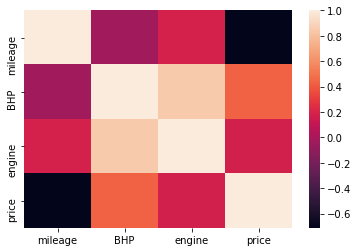

In [26]:
sns.heatmap(full_data_cleaned.corr())
plt.show()

#### A number of independent variables are highly correlated with each other, so there will be multicollinearity issues 

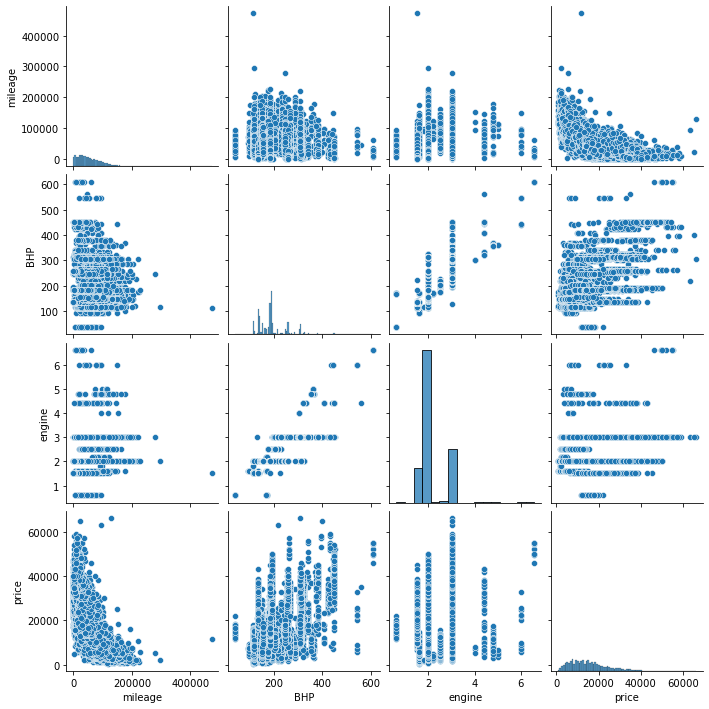

In [27]:
sns.pairplot(full_data_cleaned)
plt.show()

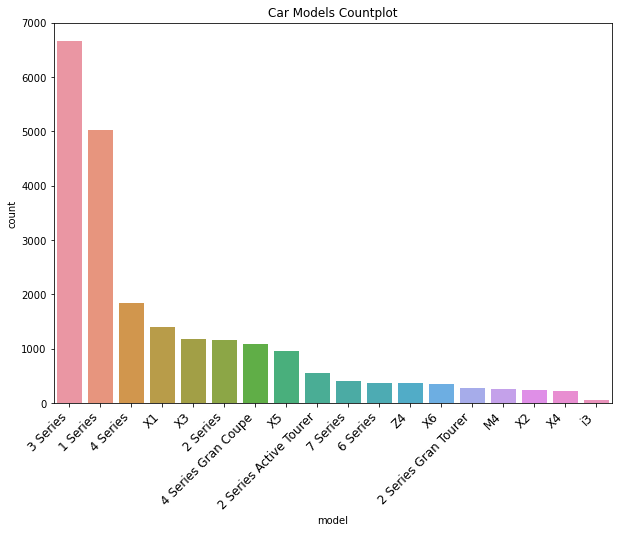

In [28]:
plt.figure(figsize=(10,7))

sns.countplot(x = 'model',
              data = full_data_cleaned,
              order = full_data_cleaned['model'].value_counts().index)

plt.xticks(rotation = 45,
           horizontalalignment='right',
           fontweight ='light',
           fontsize ='large'
          )

plt.title('Car Models Countplot')

plt.show()

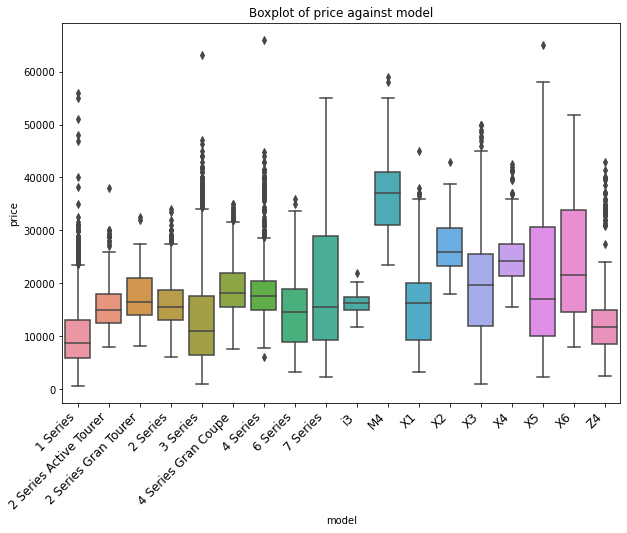

In [29]:
plt.figure(figsize=(10,7))

sns.boxplot(x = 'model',
            y = 'price',
            data = full_data_cleaned)


plt.xticks(rotation = 45,
           horizontalalignment='right',
           fontweight ='light',
           fontsize ='large'
          )

plt.title('Boxplot of price against model')

plt.show()

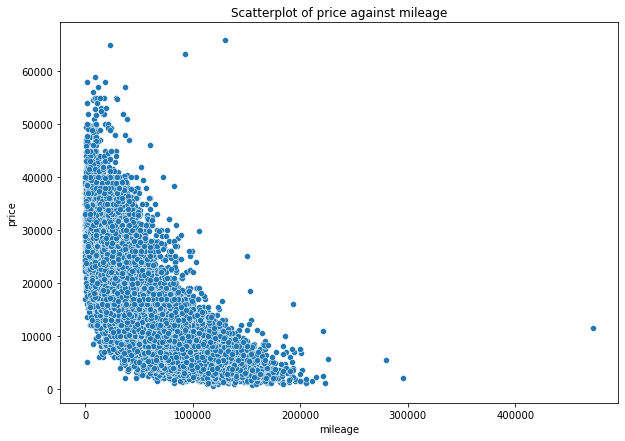

In [30]:
plt.figure(figsize=(10,7))

sns.scatterplot(x = 'mileage',
                y = 'price',
                data = full_data_cleaned)

plt.title('Scatterplot of price against mileage')

plt.show()

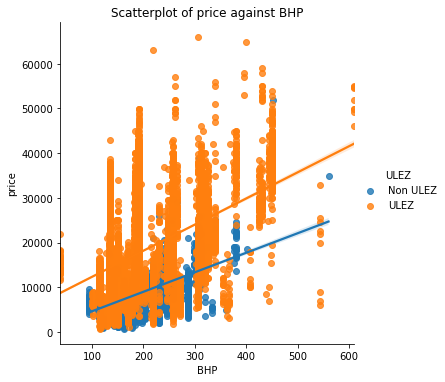

In [31]:
sns.lmplot(x = 'BHP',
           y = 'price',
           data = full_data_cleaned,
           hue = 'ULEZ')

plt.title('Scatterplot of price against BHP')

plt.show()

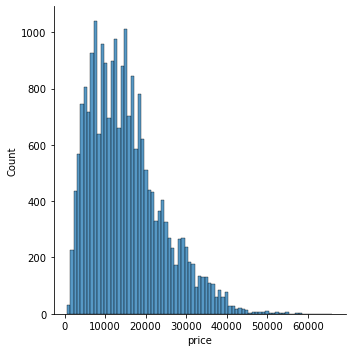

In [32]:
sns.displot(full_data_cleaned.price)
plt.show()

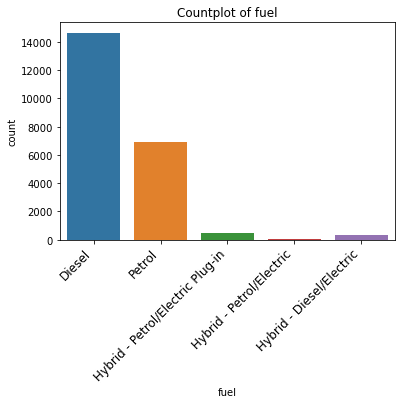

In [33]:
sns.countplot(x = 'fuel',
              data = full_data_cleaned)

plt.xticks(rotation = 45,
           horizontalalignment='right',
           fontweight ='light',
           fontsize ='large'
          )

plt.title('Countplot of fuel')

plt.show()

In [34]:
full_data_cleaned.fuel.value_counts()

Diesel                              14654
Petrol                               6916
Hybrid - Petrol/Electric Plug-in      490
Hybrid - Diesel/Electric              315
Hybrid - Petrol/Electric               71
Name: fuel, dtype: int64

- Electric cars were removed, may consider removing Hybrid - Petrol/Electric (if time permits)

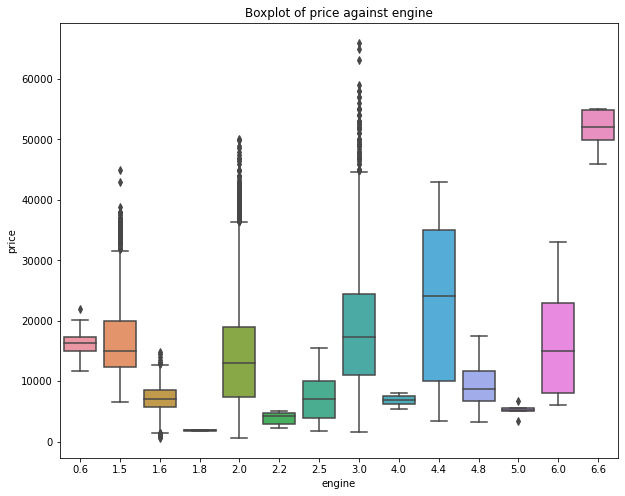

In [35]:
plt.figure(figsize = (10, 8))

sns.boxplot(x = 'engine', 
            y = 'price',
            data = full_data_cleaned)

plt.title('Boxplot of price against engine')

plt.show()

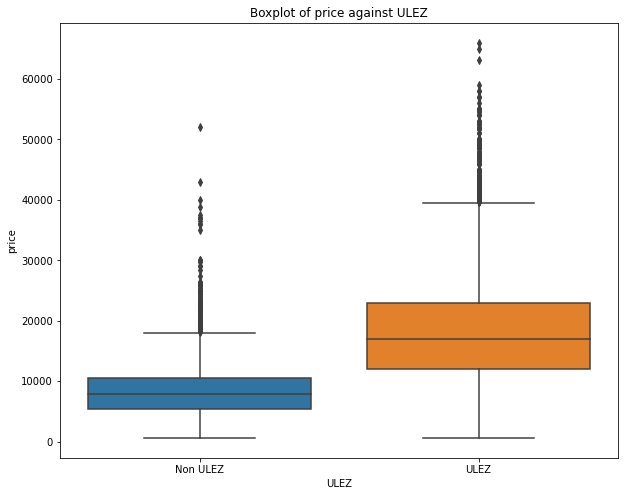

In [36]:
plt.figure(figsize = (10, 8))

sns.boxplot(x = 'ULEZ', 
            y = 'price',
            data = full_data_cleaned)

plt.title('Boxplot of price against ULEZ')

plt.show()

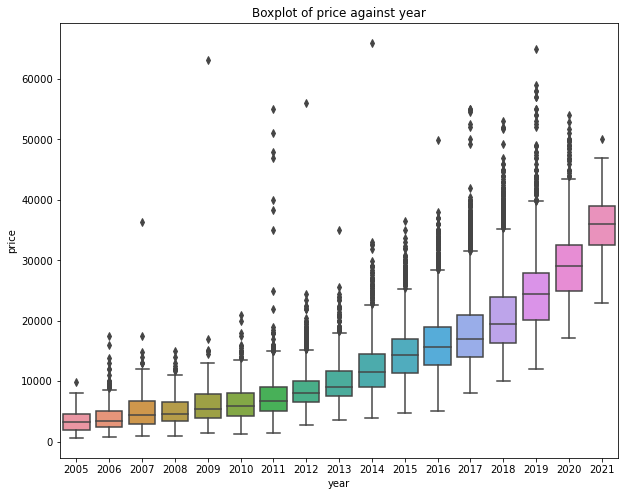

In [37]:
plt.figure(figsize = (10, 8))

sns.boxplot(x = 'year', 
            y = 'price',
            data = full_data_cleaned)

plt.title('Boxplot of price against year')

plt.show()

### Train Test Split

In [38]:
feature_cols = list(full_data_cleaned.columns)
feature_cols.remove('price')

X = full_data_cleaned[feature_cols]
y = full_data_cleaned['price']

In [39]:
## Splitting data into 0.7 training set and 0.3 testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [40]:
## Checking if training data has all the categories
variable_list = ['model', 'transmission', 'fuel', 'body', 'ULEZ']

for i in variable_list:
    unique_values(X_train, i)

The variable model has 18 unique values: 

['6 Series' '1 Series' '3 Series' 'X3' 'X1' '4 Series'
 '4 Series Gran Coupe' '7 Series' 'X4' 'i3' 'X5' 'M4' '2 Series' 'Z4'
 '2 Series Active Tourer' 'X2' 'X6' '2 Series Gran Tourer']
-------------------------------------------------------------------------- 

The variable transmission has 2 unique values: 

['Automatic' 'Manual']
-------------------------------------------------------------------------- 

The variable fuel has 5 unique values: 

['Diesel' 'Petrol' 'Hybrid - Diesel/Electric' 'Hybrid - Petrol/Electric'
 'Hybrid - Petrol/Electric Plug-in']
-------------------------------------------------------------------------- 

The variable body has 7 unique values: 

['Coupe' 'Hatchback' 'Estate' 'Saloon' 'SUV' 'Convertible' 'MPV']
-------------------------------------------------------------------------- 

The variable ULEZ has 2 unique values: 

['Non ULEZ', 'ULEZ']
Categories (2, object): ['Non ULEZ', 'ULEZ']
---------------------------

### Data Transformation of Training Set

#### Summary
1) One-hot encode categorical variables  
2) Introduce a new variable age using year  
3) Add constant term to dataset  
4) Take natural log of dependent variable  
5) Standardise the feature matrix using standard scaler

In [41]:
X_train_trans = data_trans_x(X_train)

In [42]:
X_train_trans.head()

,const,mileage,BHP,engine,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_3 Series,model_4 Series,model_4 Series Gran Coupe,...,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Petrol,body_Coupe,body_Estate,body_Hatchback,body_MPV,body_SUV,body_Saloon,ULEZ_ULEZ,age
66,1.0,82000.0,286.0,3.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,14
2575,1.0,54681.0,136.0,1.6,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,7
3311,1.0,33431.0,184.0,2.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,7
7538,1.0,6954.0,190.0,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
114,1.0,158665.0,177.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12


In [43]:
X_train_trans.columns

Index(['const', 'mileage', 'BHP', 'engine', 'model_2 Series',
       'model_2 Series Active Tourer', 'model_2 Series Gran Tourer',
       'model_3 Series', 'model_4 Series', 'model_4 Series Gran Coupe',
       'model_6 Series', 'model_7 Series', 'model_M4', 'model_X1', 'model_X2',
       'model_X3', 'model_X4', 'model_X5', 'model_X6', 'model_Z4', 'model_i3',
       'transmission_Manual', 'fuel_Hybrid - Diesel/Electric',
       'fuel_Hybrid - Petrol/Electric',
       'fuel_Hybrid - Petrol/Electric Plug-in', 'fuel_Petrol', 'body_Coupe',
       'body_Estate', 'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon',
       'ULEZ_ULEZ', 'age'],
      dtype='object')

In [44]:
X_train_trans.shape

(15712, 34)

#### Inspecting Age

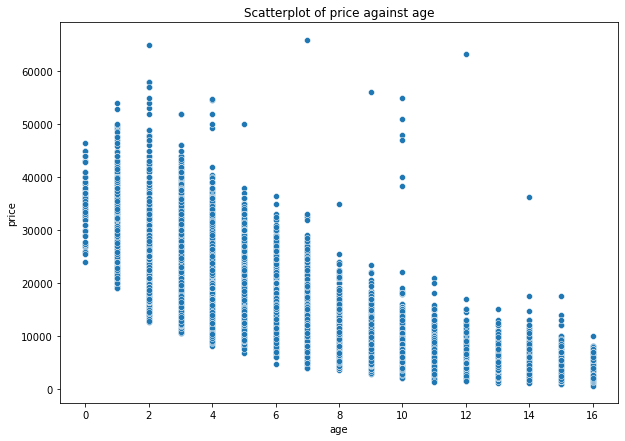

In [47]:
plt.figure(figsize=(10,7))

sns.scatterplot(x = X_train_trans.age,
                y = y_train)

plt.title('Scatterplot of price against age')

plt.show()

- The relationship is not exactly linear, logging one of them might improve

In [45]:
y_train_log = np.log(y_train)

In [46]:
y_train_log.head()

66       8.778788
2575     8.846497
3311     9.491753
7538    10.388842
114      8.202482
Name: price, dtype: float64

#### Standardisation

In [48]:
## Centering the numerical variables using z-scores
scale_list = ['mileage', 'BHP', 'engine', 'age']
scaler = StandardScaler()
X_train_trans_scaled = X_train_trans.copy()
X_train_trans_scaled[scale_list] = scaler.fit_transform(X_train_trans[scale_list])

In [49]:
## Mean of variables used in standardisation
for i in range(len(scaler.mean_)):
    print(f'{scale_list[i]}: {scaler.mean_[i]}')

mileage: 52956.48389765784
BHP: 195.03933299389
engine: 2.1659686863543786
age: 6.372008655804481


In [50]:
## Variance of variables used in standardisation
for i in range(len(scaler.var_)):
    print(f'{scale_list[i]}: {scaler.var_[i]}')

mileage: 1378138691.6011918
BHP: 4097.748834789319
engine: 0.27467753669766337
age: 14.12045630135074


In [51]:
## Standard deviation of variables used in standardisation
for i in range(len(scaler.scale_)):
    print(f'{scale_list[i]}: {scaler.scale_[i]}')

mileage: 37123.29041991283
BHP: 64.01366131373301
engine: 0.5240968772065555
age: 3.7577195612965504


In [52]:
X_train_trans_scaled

,const,mileage,BHP,engine,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_3 Series,model_4 Series,model_4 Series Gran Coupe,...,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Petrol,body_Coupe,body_Estate,body_Hatchback,body_MPV,body_SUV,body_Saloon,ULEZ_ULEZ,age
66,1.0,0.782353,1.420957,1.591369,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2.029952
2575,1.0,0.046454,-0.922293,-1.079893,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0.167120
3311,1.0,-0.525963,-0.172453,-0.316676,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.167120
7538,1.0,-1.239181,-0.078723,-0.316676,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,-1.429593
114,1.0,2.847499,-0.281804,-0.316676,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.497715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,1.0,-0.961512,2.045824,1.591369,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,-0.631236
1174,1.0,-0.327220,0.983550,1.591369,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,-0.631236
571,1.0,-0.685297,-0.922293,-1.270698,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,-0.897355
877,1.0,1.617408,-1.234726,-0.316676,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.231596


### Data Transformation of Testing Set

In [53]:
X_test_trans = data_trans_x(X_test)

In [54]:
X_test_trans.head()

,const,mileage,BHP,engine,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_3 Series,model_4 Series,model_4 Series Gran Coupe,...,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Petrol,body_Coupe,body_Estate,body_Hatchback,body_MPV,body_SUV,body_Saloon,ULEZ_ULEZ,age
134,1.0,143000.0,265.0,3.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,14
3887,1.0,30868.0,116.0,1.5,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,5
8006,1.0,3500.0,192.0,2.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
679,1.0,20299.0,192.0,2.0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,2
840,1.0,37306.0,190.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,4


In [55]:
X_test_trans.columns

Index(['const', 'mileage', 'BHP', 'engine', 'model_2 Series',
       'model_2 Series Active Tourer', 'model_2 Series Gran Tourer',
       'model_3 Series', 'model_4 Series', 'model_4 Series Gran Coupe',
       'model_6 Series', 'model_7 Series', 'model_M4', 'model_X1', 'model_X2',
       'model_X3', 'model_X4', 'model_X5', 'model_X6', 'model_Z4', 'model_i3',
       'transmission_Manual', 'fuel_Hybrid - Diesel/Electric',
       'fuel_Hybrid - Petrol/Electric',
       'fuel_Hybrid - Petrol/Electric Plug-in', 'fuel_Petrol', 'body_Coupe',
       'body_Estate', 'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon',
       'ULEZ_ULEZ', 'age'],
      dtype='object')

In [56]:
X_test_trans.shape

(6734, 34)

In [57]:
X_test_trans_scaled = X_test_trans.copy()
X_test_trans_scaled[scale_list] = scaler.transform(X_test_trans[scale_list])

In [58]:
y_test_log = np.log(y_test)

### Regression - Full

In [59]:
lin_reg = sm.OLS(y_train, X_train_trans)
model_full = lin_reg.fit()
predicted_full = model_full.predict(X_train_trans)

rmse_full = statsmodels.tools.eval_measures.rmse(y_train, predicted_full)
    
print(f'rmse = {rmse_full}')
print(model_full.summary())

rmse = 3123.0517955184205
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     3497.
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        16:34:04   Log-Likelihood:            -1.4872e+05
No. Observations:               15712   AIC:                         2.975e+05
Df Residuals:                   15679   BIC:                         2.978e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Regression - Full (Testing)

In [60]:
predicted_test = model_full.predict(X_test_trans)

rmse_full_test = statsmodels.tools.eval_measures.rmse(y_test, predicted_test)
rmse_full_test

3003.6273765184296

In [61]:
r_squared(y_test, predicted_test)

0.8853704384381572

### Regression - Full (Log)

In [62]:
lin_reg = sm.OLS(y_train_log, X_train_trans)
model_full = lin_reg.fit()
predicted_full = model_full.predict(X_train_trans)

rmse_full = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_full)
    
print(f'rmse = {rmse_full}')
print(model_full.summary())

rmse = 0.1528464877223865
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     8702.
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        16:34:04   Log-Likelihood:                 7217.8
No. Observations:               15712   AIC:                        -1.437e+04
Df Residuals:                   15679   BIC:                        -1.412e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Regression - Full (Testing)

In [63]:
predicted_test = model_full.predict(X_test_trans)

rmse_full_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test)
rmse_full_test

0.14623286927293364

In [64]:
r_squared(y_test_log, predicted_test)

0.9496758102585395

### Stepwise Regression

In [65]:
X_train_trans.columns

Index(['const', 'mileage', 'BHP', 'engine', 'model_2 Series',
       'model_2 Series Active Tourer', 'model_2 Series Gran Tourer',
       'model_3 Series', 'model_4 Series', 'model_4 Series Gran Coupe',
       'model_6 Series', 'model_7 Series', 'model_M4', 'model_X1', 'model_X2',
       'model_X3', 'model_X4', 'model_X5', 'model_X6', 'model_Z4', 'model_i3',
       'transmission_Manual', 'fuel_Hybrid - Diesel/Electric',
       'fuel_Hybrid - Petrol/Electric',
       'fuel_Hybrid - Petrol/Electric Plug-in', 'fuel_Petrol', 'body_Coupe',
       'body_Estate', 'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon',
       'ULEZ_ULEZ', 'age'],
      dtype='object')

In [66]:
stepwise_result = stepwise_selection(X_train_trans[['mileage', 'BHP', 'engine', 'model_2 Series',
                                              'model_2 Series Active Tourer', 'model_2 Series Gran Tourer',
                                              'model_3 Series', 'model_4 Series', 'model_4 Series Gran Coupe',
                                              'model_6 Series', 'model_7 Series', 'model_M4', 'model_X1', 'model_X2',
                                              'model_X3', 'model_X4', 'model_X5', 'model_X6', 'model_Z4', 'model_i3',
                                              'transmission_Manual', 'fuel_Hybrid - Diesel/Electric',
                                              'fuel_Hybrid - Petrol/Electric',
                                              'fuel_Hybrid - Petrol/Electric Plug-in', 'fuel_Petrol', 'body_Coupe',
                                              'body_Estate', 'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon',
                                              'ULEZ_ULEZ', 'age']], y_train_log)

print('resulting features:')
print(stepwise_result)

Add  ULEZ_ULEZ                      with p-value 0.0
Add  BHP                            with p-value 0.0
Add  transmission_Manual            with p-value 0.0
Add  mileage                        with p-value 0.0
Add  fuel_Petrol                    with p-value 0.0
Add  age                            with p-value 0.0
Add  model_X5                       with p-value 0.0
Add  body_SUV                       with p-value 0.0
Add  model_Z4                       with p-value 1.63156e-195
Add  model_X1                       with p-value 4.93626e-103
Add  body_Hatchback                 with p-value 2.96944e-79
Add  body_MPV                       with p-value 8.00344e-69
Add  body_Saloon                    with p-value 4.20321e-67
Add  model_7 Series                 with p-value 6.16781e-61
Add  model_4 Series Gran Coupe      with p-value 4.5703e-65
Add  model_2 Series                 with p-value 4.88558e-51
Add  model_X6                       with p-value 1.04488e-42
Add  model_6 Series       

In [67]:
## Stepwise model
variables = ['const','BHP', 'mileage', 'age', 'model_X5', 
             'transmission_Manual', 'model_Z4', 'body_Hatchback', 
             'body_MPV', 'model_4 Series Gran Coupe', 'body_Saloon', 
             'model_7 Series', 'model_X6', 'model_6 Series', 'model_X2', 
             'body_Coupe', 'body_Estate', 'model_3 Series', 'model_4 Series', 
             'fuel_Hybrid - Petrol/Electric', 'fuel_Hybrid - Petrol/Electric Plug-in', 
             'fuel_Hybrid - Diesel/Electric', 'model_X4', 'model_M4', 
             'engine', 'fuel_Petrol', 'model_X3']

lin_reg = sm.OLS(y_train_log, X_train_trans[variables])
model_step = lin_reg.fit()
predicted_step = model_step.predict(X_train_trans[variables])

rmse_step = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_step)
    
print(f'rmse = {rmse_step}')
print(model_step.summary())

rmse = 0.15292900372050844
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.070e+04
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        16:34:10   Log-Likelihood:                 7209.3
No. Observations:               15712   AIC:                        -1.436e+04
Df Residuals:                   15685   BIC:                        -1.416e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

#### Stepwise Regression (Testing)

In [68]:
predicted_test_step = model_step.predict(X_test_trans[variables])

rmse_step_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test_step)
rmse_step_test

0.1462631405027203

In [69]:
r_squared(y_test_log, predicted_test_step)

0.9496549731814347

### VIF

In [70]:
cols = variables[1:]
calculate_vif(X_train_trans[cols])

dropping 'engine' at index: 23
dropping 'age' at index: 2
dropping 'BHP' at index: 0
dropping 'model_3 Series' at index: 14
Remaining variables:
Index(['mileage', 'model_X5', 'transmission_Manual', 'model_Z4',
       'body_Hatchback', 'body_MPV', 'model_4 Series Gran Coupe',
       'body_Saloon', 'model_7 Series', 'model_X6', 'model_6 Series',
       'model_X2', 'body_Coupe', 'body_Estate', 'model_4 Series',
       'fuel_Hybrid - Petrol/Electric',
       'fuel_Hybrid - Petrol/Electric Plug-in',
       'fuel_Hybrid - Diesel/Electric', 'model_X4', 'model_M4', 'fuel_Petrol',
       'model_X3'],
      dtype='object')


,mileage,model_X5,transmission_Manual,model_Z4,body_Hatchback,body_MPV,model_4 Series Gran Coupe,body_Saloon,model_7 Series,model_X6,...,body_Coupe,body_Estate,model_4 Series,fuel_Hybrid - Petrol/Electric,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Hybrid - Diesel/Electric,model_X4,model_M4,fuel_Petrol,model_X3
66,82000.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2575,54681.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3311,33431.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7538,6954.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
114,158665.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,17262.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1174,40809.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
571,27516.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
877,113000.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
vif_list = ['const','mileage', 'model_X5', 'transmission_Manual', 'model_Z4',
            'body_Hatchback', 'body_MPV', 'model_4 Series Gran Coupe',
            'body_Saloon', 'model_7 Series', 'model_X6', 'model_6 Series',
            'model_X2', 'body_Coupe', 'body_Estate', 'model_4 Series',
            'fuel_Hybrid - Petrol/Electric', 'fuel_Hybrid - Petrol/Electric Plug-in',
            'fuel_Hybrid - Diesel/Electric', 'model_X4', 'model_M4', 'fuel_Petrol', 'model_X3']

lin_reg = sm.OLS(y_train_log, X_train_trans[vif_list])
model_vif = lin_reg.fit()
predicted_vif = model_vif.predict(X_train_trans[vif_list])

rmse_vif = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_vif)
    
print(f'rmse = {rmse_vif}')
print(model_vif.summary())

rmse = 0.295889937375354
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     2857.
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        16:34:12   Log-Likelihood:                -3160.8
No. Observations:               15712   AIC:                             6368.
Df Residuals:                   15689   BIC:                             6544.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#### VIF (Testing)

In [72]:
predicted_test_vif = model_vif.predict(X_test_trans[vif_list])

rmse_vif_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test_vif)
rmse_vif_test

0.28484370298888084

In [73]:
r_squared(y_test_log, predicted_test_vif)

0.8090586300575278

### Best OLS Model

In [74]:
best = ['const', 'model_2 Series', 'model_2 Series Active Tourer', 'model_2 Series Gran Tourer',
       'model_3 Series', 'model_4 Series', 'model_4 Series Gran Coupe',
       'model_6 Series', 'model_7 Series', 'model_M4', 'model_X1', 'model_X2',
       'model_X3', 'model_X4', 'model_X5', 'model_X6', 'model_Z4', 'model_i3',
       'transmission_Manual', 'ULEZ_ULEZ', 'age', 'engine']

lin_reg = sm.OLS(y_train_log, X_train_trans[best])
model_best = lin_reg.fit()
predicted_best = model_best.predict(X_train_trans[best])

rmse_best = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_best)
    
print(f'rmse = {rmse_best}')
print(model_best.summary())

rmse = 0.21009867752802625
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     6671.
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        16:34:12   Log-Likelihood:                 2219.2
No. Observations:               15712   AIC:                            -4394.
Df Residuals:                   15690   BIC:                            -4226.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

#### Best OLS Model (Testing)

In [75]:
predicted_test_best = model_best.predict(X_test_trans[best])

rmse_best_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test_best)
rmse_best_test

0.20722894657074759

In [76]:
r_squared(y_test_log, predicted_test_best)

0.8989380609255564

### Elastic Net

In [77]:
#cols = list(X_train_trans_scaled.columns)
lin_reg = sm.OLS(y_train_log, X_train_trans_scaled)
results = lin_reg.fit_regularized(method = 'elastic_net', alpha = 0.0, L1_wt = 1.0, start_params = None, profile_scale = False, refit = False)
results.params

const                                    9.497899
mileage                                 -0.203613
BHP                                      0.140633
engine                                   0.010551
model_2 Series                          -0.009877
model_2 Series Active Tourer            -0.243779
model_2 Series Gran Tourer              -0.210227
model_3 Series                           0.130316
model_4 Series                           0.099607
model_4 Series Gran Coupe                0.143962
model_6 Series                           0.198864
model_7 Series                           0.337289
model_M4                                 0.097089
model_X1                                -0.019487
model_X2                                 0.011571
model_X3                                 0.150607
model_X4                                 0.240455
model_X5                                 0.357493
model_X6                                 0.314023
model_Z4                                 0.274790


In [78]:
predicted_elastic = results.predict(X_train_trans_scaled)

rmse_elastic = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_elastic)
rmse_elastic

0.15288096032036785

In [79]:
r_squared(y_train_log, predicted_elastic)

0.9466705268898818

#### Elastic Net (Testing)

In [80]:
predicted_test_elastic = results.predict(X_test_trans_scaled)

rmse_elastic_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test_elastic)
rmse_elastic_test

0.14626116641020107

In [81]:
r_squared(y_test_log, predicted_test_elastic)

0.9496563321714

### Lasso Regression

In [82]:
lin_lasso = sm.OLS(y_train_log, X_train_trans_scaled)
results_lasso = lin_lasso.fit_regularized(method = 'sqrt_lasso', alpha = 0.1, L1_wt = 1, start_params = None, profile_scale = False, refit = False)
results_lasso.params

const                                    9.481953
mileage                                 -0.203858
BHP                                      0.140372
engine                                   0.010626
model_2 Series                           0.001984
model_2 Series Active Tourer            -0.033858
model_2 Series Gran Tourer               0.000012
model_3 Series                           0.144169
model_4 Series                           0.112214
model_4 Series Gran Coupe                0.144801
model_6 Series                           0.211840
model_7 Series                           0.351964
model_M4                                 0.110191
model_X1                                 0.153516
model_X2                                 0.184698
model_X3                                 0.324001
model_X4                                 0.414096
model_X5                                 0.530878
model_X6                                 0.487774
model_Z4                                 0.288867


In [83]:
predicted_lasso = results_lasso.predict(X_train_trans_scaled)

rmse_lasso = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_lasso)
rmse_lasso

0.15284884405499694

In [84]:
r2_lasso = r_squared(y_train_log, predicted_lasso)
r2_lasso

0.9466929307733444

In [85]:
rmse_unlog(y_train_log, predicted_lasso)

2347.561984845034

#### Lasso Regression (Testing)

In [86]:
predicted_test_lasso = results_lasso.predict(X_test_trans_scaled)

rmse_lasso_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test_lasso)
rmse_lasso_test

0.14621775388897884

In [87]:
r2_lasso_test = r_squared(y_test_log, predicted_test_lasso)
r2_lasso_test

0.9496862132567243

In [88]:
rmse_unlog(y_test_log, predicted_test_lasso)

2128.176789591586

### Grid Search - Ridge

In [89]:
## A range of alpha values to test

alphas = np.array([1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0])

In [90]:
## Create and fit a ridge regression model, testing each alpha
## Can try random search if there is time
model = Ridge()
grid = GridSearchCV(estimator = model, param_grid = dict(alpha = alphas))
grid.fit(X_train_trans_scaled, y_train_log)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.   , 0.5  , 0.1  , 0.05 , 0.01 , 0.005, 0.001, 0.   ])})
0.9462914395206103
0.5


### Ridge Regression

In [91]:
lin_reg = sm.OLS(y_train_log, X_train_trans_scaled)
results = lin_reg.fit_regularized(method = 'sqrt_lasso', alpha = 0.5, L1_wt = 0, start_params = None, profile_scale = False, refit = False)
results.params

const                                    9.482803e+00
mileage                                 -2.038730e-01
BHP                                      1.404964e-01
engine                                   1.060374e-02
model_2 Series                           7.476682e-04
model_2 Series Active Tourer            -3.363158e-02
model_2 Series Gran Tourer               3.743451e-08
model_3 Series                           1.424412e-01
model_4 Series                           1.109224e-01
model_4 Series Gran Coupe                1.444932e-01
model_6 Series                           2.102345e-01
model_7 Series                           3.497905e-01
model_M4                                 1.082035e-01
model_X1                                -1.428333e-06
model_X2                                 3.077065e-02
model_X3                                 1.702700e-01
model_X4                                 2.600014e-01
model_X5                                 3.772160e-01
model_X6                    

#### Get more accurate coefficients

In [92]:
for i in range(len(results.params)):
    print(f'{results.params.index[i]}: {results.params[i]}')

const: 9.482803428335483
mileage: -0.2038730123501245
BHP: 0.14049637410062918
engine: 0.010603735163639324
model_2 Series: 0.0007476681938264962
model_2 Series Active Tourer: -0.03363157839887766
model_2 Series Gran Tourer: 3.743451487694052e-08
model_3 Series: 0.14244121794277823
model_4 Series: 0.11092236114975539
model_4 Series Gran Coupe: 0.14449321601017384
model_6 Series: 0.2102345126552158
model_7 Series: 0.3497904615230327
model_M4: 0.10820354601311888
model_X1: -1.4283334006657984e-06
model_X2: 0.030770647972964676
model_X3: 0.17026999815775481
model_X4: 0.26000141425231527
model_X5: 0.3772160257440536
model_X6: 0.3337038989297259
model_Z4: 0.28760777467275905
model_i3: 0.20010533449910636
transmission_Manual: -0.1167852432580011
fuel_Hybrid - Diesel/Electric: 0.09320793466682657
fuel_Hybrid - Petrol/Electric: 0.018233586005435443
fuel_Hybrid - Petrol/Electric Plug-in: 0.08474606186539155
fuel_Petrol: -0.011241351682942883
body_Coupe: -0.08638882771829881
body_Estate: -0.1462

In [93]:
predicted_ridge = results.predict(X_train_trans_scaled)

rmse_ridge = statsmodels.tools.eval_measures.rmse(y_train_log, predicted_ridge)
rmse_ridge

0.15286074881291864

In [94]:
r2_ridge = r_squared(y_train_log, predicted_ridge)
r2_ridge

0.9466846267201204

In [95]:
rmse_unlog(y_train_log, predicted_ridge)

2347.564711995735

#### Ridge Regression (Testing)

In [96]:
predicted_test_ridge = results.predict(X_test_trans_scaled)

rmse_ridge_test = statsmodels.tools.eval_measures.rmse(y_test_log, predicted_test_ridge)
rmse_ridge_test

0.1462223325894648

In [97]:
r2_ridge_test = r_squared(y_test_log, predicted_test_ridge)
r2_ridge_test

0.949683062129578

In [98]:
rmse_unlog(y_test_log, predicted_test_ridge)

2128.2643561430914

### Modelling Results

Among all the models attempted, Ridge regression performs the best in terms of R-squared and RMSE values

### Assumptions Checking - Training

In [99]:
resid = y_train_log - predicted_ridge

#### Linearity

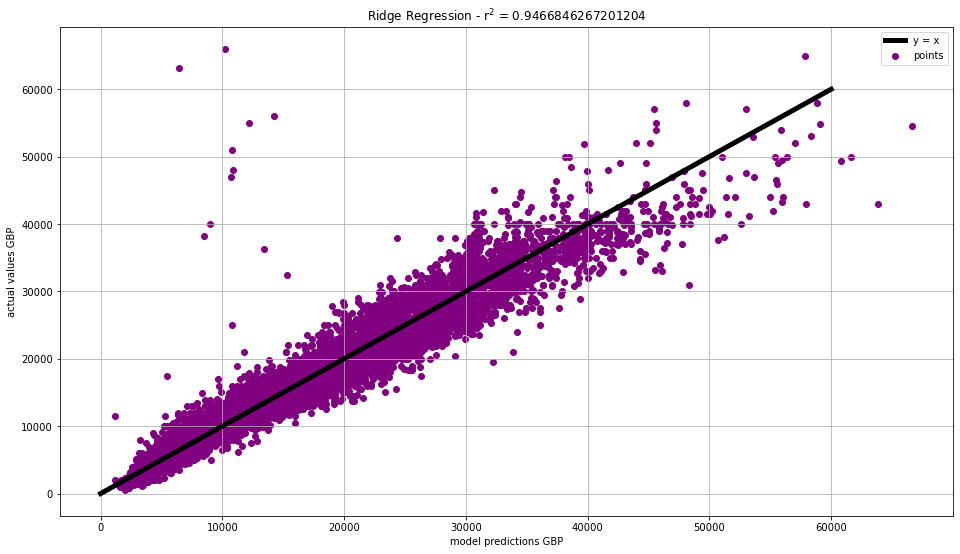

In [100]:
plt.figure(figsize = (16,9)) 

plt.xlabel('model predictions GBP') 
plt.ylabel('actual values GBP') 
plt.plot(np.linspace(0,60000,1000),np.linspace(0,60000,1000),color='black',linewidth=5) 
plt.scatter(x = np.exp(predicted_ridge), y = np.exp(y_train_log), color = 'purple') 
plt.legend(['y = x','points'])

## Change your title with your r^2 value
plt.title(f'Ridge Regression - r$^2$ = {r2_ridge}')
plt.grid()
plt.show()

C:\Users\brian\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


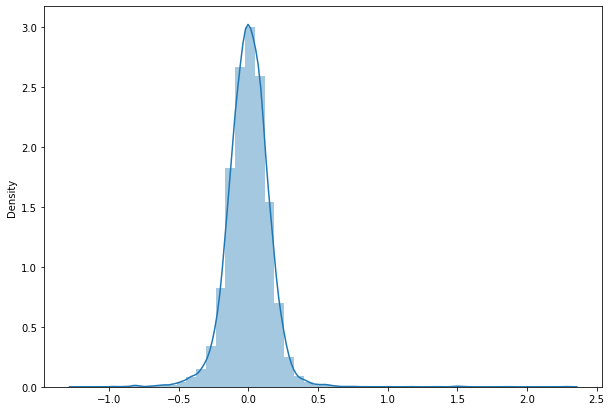

In [101]:
plt.figure(figsize = (10, 7))
sns.distplot(resid)
plt.show()

In [102]:
resid.values

array([-0.06018669, -0.14019341,  0.1178349 , ..., -0.02652397,
       -0.27721229, -0.07346689])

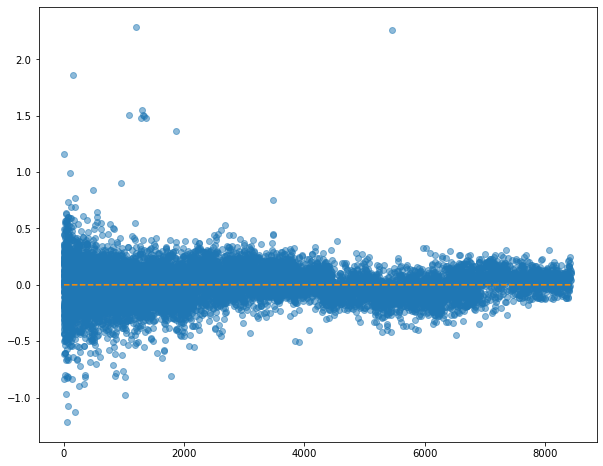

In [103]:
plt.figure(figsize = (10, 8))
plt.scatter(x = resid.index, y = resid.values, alpha = 0.5)
plt.plot(np.repeat(0, resid.index.max()), color = 'darkorange', linestyle = '--')
plt.show()

### Assumptions Checking - Testing Set

In [104]:
resid_test = y_test_log - predicted_test_ridge

#### Linearity

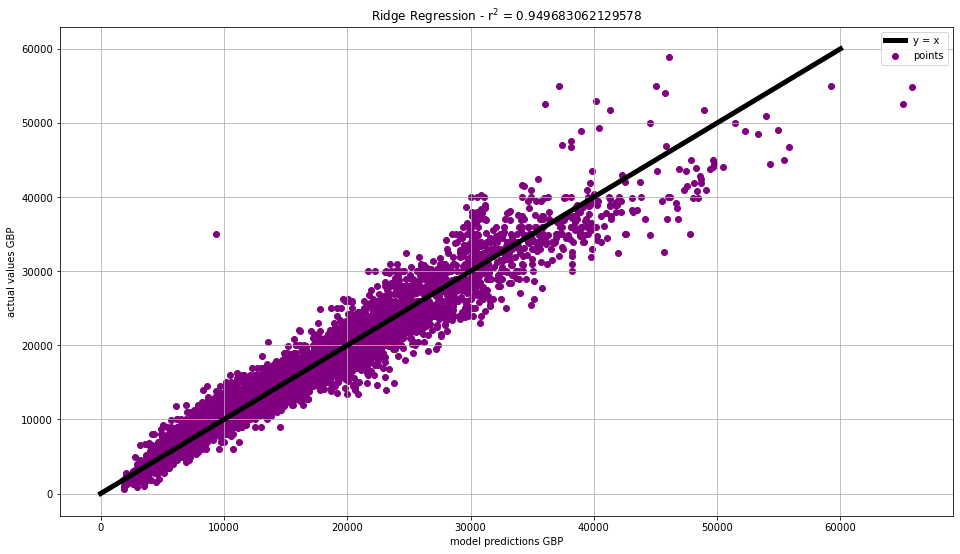

In [105]:
plt.figure(figsize=(16,9)) 

plt.xlabel('model predictions GBP') 
plt.ylabel('actual values GBP') 
plt.plot(np.linspace(0, 60000, 1000),np.linspace(0, 60000, 1000), color = 'black',linewidth = 5) 
plt.scatter(x = np.exp(predicted_test_ridge), y = np.exp(y_test_log), color = 'purple') 
plt.legend(['y = x','points'])

## Change your title with your r^2 value
plt.title(f'Ridge Regression - r$^2$ = {r2_ridge_test}')
plt.grid()
plt.show()

C:\Users\brian\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


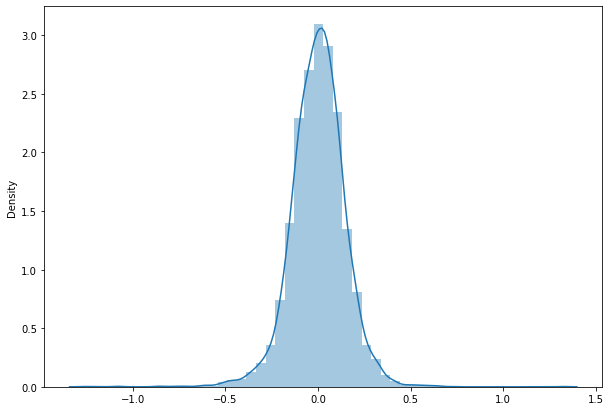

In [106]:
plt.figure(figsize = (10, 7))
sns.distplot(resid_test)
plt.show()

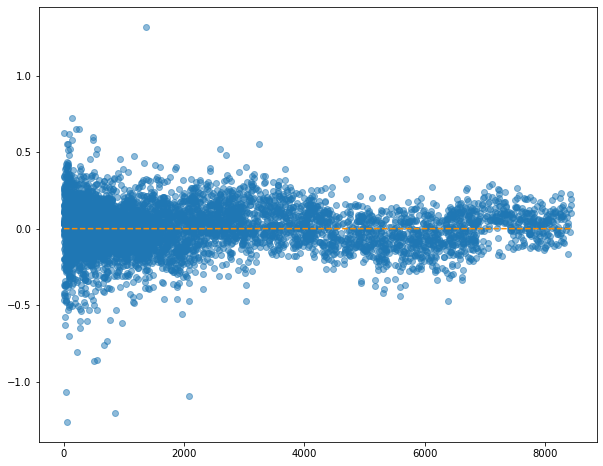

In [107]:
plt.figure(figsize = (10, 8))
plt.scatter(x = resid_test.index, y = resid_test.values, alpha = 0.5)
plt.plot(np.repeat(0, resid_test.index.max()), color = 'darkorange', linestyle = '--')
plt.show()

### Conclusion

The ridge regression model performs the best and does not show significant violation of the assumptions. A function that incorporates business rules to suggest a profitable price for purchasing the used cars will be created (See the other notebook)

### Test Case Generation for Final Function

In [108]:
test_cols = X_test_trans.columns

for i in test_cols:
    print(i, X_test_trans.head()[i])

const 134     1.0
3887    1.0
8006    1.0
679     1.0
840     1.0
Name: const, dtype: float64
mileage 134     143000.0
3887     30868.0
8006      3500.0
679      20299.0
840      37306.0
Name: mileage, dtype: float64
BHP 134     265.0
3887    116.0
8006    192.0
679     192.0
840     190.0
Name: BHP, dtype: float64
engine 134     3.0
3887    1.5
8006    2.0
679     2.0
840     2.0
Name: engine, dtype: float64
model_2 Series 134     0
3887    0
8006    0
679     0
840     0
Name: model_2 Series, dtype: uint8
model_2 Series Active Tourer 134     0
3887    0
8006    0
679     1
840     0
Name: model_2 Series Active Tourer, dtype: uint8
model_2 Series Gran Tourer 134     0
3887    0
8006    0
679     0
840     0
Name: model_2 Series Gran Tourer, dtype: uint8
model_3 Series 134     0
3887    0
8006    1
679     0
840     0
Name: model_3 Series, dtype: uint8
model_4 Series 134     0
3887    0
8006    0
679     0
840     0
Name: model_4 Series, dtype: uint8
model_4 Series Gran Coupe 134     0

#### Test Case 1

In [109]:
X_test_trans[X_test_trans.index == 134].head(1)

,const,mileage,BHP,engine,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_3 Series,model_4 Series,model_4 Series Gran Coupe,...,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Petrol,body_Coupe,body_Estate,body_Hatchback,body_MPV,body_SUV,body_Saloon,ULEZ_ULEZ,age
134,1.0,143000.0,265.0,3.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,14


In [110]:
np.exp(predicted_test_ridge[predicted_test_ridge.index == 134]).head(1)

134    3153.667102
dtype: float64

#### Test Case 2

In [111]:
X_test_trans[X_test_trans.index == 3887].head(1)

,const,mileage,BHP,engine,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_3 Series,model_4 Series,model_4 Series Gran Coupe,...,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Petrol,body_Coupe,body_Estate,body_Hatchback,body_MPV,body_SUV,body_Saloon,ULEZ_ULEZ,age
3887,1.0,30868.0,116.0,1.5,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,5


In [112]:
np.exp(predicted_test_ridge[predicted_test_ridge.index == 3887]).head(1)

3887    10927.252684
dtype: float64

#### Test Case 3

In [113]:
X_test_trans[X_test_trans.index == 8006]

,const,mileage,BHP,engine,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_3 Series,model_4 Series,model_4 Series Gran Coupe,...,fuel_Hybrid - Petrol/Electric Plug-in,fuel_Petrol,body_Coupe,body_Estate,body_Hatchback,body_MPV,body_SUV,body_Saloon,ULEZ_ULEZ,age
8006,1.0,3500.0,192.0,2.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1


In [114]:
np.exp(predicted_test_ridge[predicted_test_ridge.index == 8006])

8006    30609.416906
dtype: float64